In [33]:
!pip install transformers
!pip install nltk
import nltk
#from nltk.corpus import stopwords


import json
import pandas as pd

import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

from fastai.text import *
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten

from tensorflow import keras
from tensorflow.keras import layers

#nltk.download('stopwords')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
code_path = "/content/gdrive/MyDrive/tebano"
sys.path.append(os.path.abspath(code_path))


Mounted at /content/gdrive/


In [ ]:
from model_wrappers import bert_huggingface_model_wrapper
from transformers import AutoModelForSequenceClassification,AutoTokenizer,BertConfig, TFAutoModel, AutoConfig

import explainer
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from models import *
from visualizer import LocalExplanationReportVisualizer

from legal_bert_local_explainer import clean_text

In [ ]:
f = open('/content/gdrive/MyDrive/ECHR_Corpus.json')
echr = json.load(f)
len(echr)

42

# Collect all clauses and argument information

In [ ]:
args = []
all_clauses = []
for i in range(len(echr)):
  args.append(echr[i]['arguments'])
  all_clauses.extend(echr[i]["clauses"])
args[0][1]
len(all_clauses)

10456

In [ ]:
premises = []
for a in args:
  for d in a: 
    for id in d['premises']:
      premises.append(id)
print(len(premises))

1951


In [ ]:
conclusions = []
for a in args:
  for d in a:
    conclusions.append(d['conclusion'])
print(len(conclusions))

743


In [ ]:
num_clauses = len(all_clauses)
indices = np.random.choice(num_clauses, size=num_clauses, replace=False)
train_indices = indices[:int(0.9*num_clauses)]
test_indices = indices[int(0.9*num_clauses):]

test_ids=[]
for i in range(num_clauses):
  if i in test_indices:
    test_ids.append(all_clauses[i]["_id"])

len(test_ids)

1046

In [ ]:
"""def remove_stop_words(text):
  stop_words = stopwords.words("english")
  text = " ".join([w for w in text.split() if w not in stop_words])
  return text  """

# Collect dataset, adding context clauses

In [ ]:
n_context_clauses = 3
big_dict = {'ID' : [], 'TEXT' : [],'SEQ_START' : [], 'SEQ_END' : []}
list_of_dicts = []
for i in range(len(echr)):
  txt = echr[i]['text']
  echr[i]['clauses'].sort(key=lambda x: x["start"])
  clauses = echr[i]['clauses']

  for i in range(len(clauses)):
    context=""
    for j in range(min(i,n_context_clauses),0,-1):
      
      if clauses[i-j]["_id"] not in test_ids: #what happens if current clause[i] is part of the test set?
        context += txt[clauses[i-j]["start"]:clauses[i-j]["end"]]
    
    clauses[i]["context"] = context

  d = {'ID':[d['_id'] for d in clauses], 'TEXT': [txt[d['start']:d['end']] for d in clauses],'SEQ_START': [d['start'] for d in clauses],'SEQ_END': [d['end'] for d in clauses], 'CONTEXT':[d["context"] for d in clauses]}
  list_of_dicts.append(d)


In [ ]:
dfs = pd.concat([pd.DataFrame(dfs) for dfs in list_of_dicts])

In [ ]:
dfs

,ID,TEXT,SEQ_START,SEQ_END,CONTEXT
0,5d3fbf383e582511aa1cc856,The European Commission of Human Rights sittin...,182,297,
1,5d3fbf3d3e582511aa1cc857,Having regard to Article 25 of the Convention ...,917,1023,The European Commission of Human Rights sittin...
2,5d3fbf413e582511aa1cc858,Having regard to the application introduced on...,1027,1179,The European Commission of Human Rights sittin...
3,5d3fbf443e582511aa1cc859,Having regard to:,1181,1198,The European Commission of Human Rights sittin...
4,5d3fbfa03e582511aa1cc85a,reports provided for in Rule 47 of the Rules o...,1208,1284,Having regard to Article 25 of the Convention ...
...,...,...,...,...,...
364,5f943e0bbf181507836fa258,I refer once more to my dissenting opinion ann...,74512,75024,"With regret, I part company with the majority ..."
365,5f943e35bf181507836fa259,I consider too that in the present case Mr Ahm...,75025,75561,that the Court cannot deal with the merits of ...
366,5f943dfabf181507836fa257,In these accusations and in his conviction the...,75562,75916,that the Court cannot deal with the merits of ...
367,5f943d86bf181507836fa255,Article 27 of the Convention (art. 27) require...,75917,76264,I refer once more to my dissenting opinion ann...


In [ ]:
dfs = dfs.reset_index(drop=True)

In [ ]:
dfs['IS_PREMISE'] = dfs.apply(lambda row: 1 if row.ID in premises else 0, axis=1)

In [ ]:
dfs['IS_CONCLUSION'] = dfs.apply(lambda row: 1 if row.ID in conclusions else 0, axis=1)

In [ ]:
dfs['LABEL'] = dfs.apply(lambda row: 1 if row.IS_PREMISE == 1 or row.IS_CONCLUSION ==1 else 0, axis=1)

In [ ]:
dfs

,ID,TEXT,SEQ_START,SEQ_END,CONTEXT,IS_PREMISE,IS_CONCLUSION,LABEL
0,5d3fbf383e582511aa1cc856,The European Commission of Human Rights sittin...,182,297,,0,0,0
1,5d3fbf3d3e582511aa1cc857,Having regard to Article 25 of the Convention ...,917,1023,The European Commission of Human Rights sittin...,0,0,0
2,5d3fbf413e582511aa1cc858,Having regard to the application introduced on...,1027,1179,The European Commission of Human Rights sittin...,0,0,0
3,5d3fbf443e582511aa1cc859,Having regard to:,1181,1198,The European Commission of Human Rights sittin...,0,0,0
4,5d3fbfa03e582511aa1cc85a,reports provided for in Rule 47 of the Rules o...,1208,1284,Having regard to Article 25 of the Convention ...,0,0,0
...,...,...,...,...,...,...,...,...
10451,5f943e0bbf181507836fa258,I refer once more to my dissenting opinion ann...,74512,75024,"With regret, I part company with the majority ...",0,0,0
10452,5f943e35bf181507836fa259,I consider too that in the present case Mr Ahm...,75025,75561,that the Court cannot deal with the merits of ...,0,0,0
10453,5f943dfabf181507836fa257,In these accusations and in his conviction the...,75562,75916,that the Court cannot deal with the merits of ...,0,0,0
10454,5f943d86bf181507836fa255,Article 27 of the Convention (art. 27) require...,75917,76264,I refer once more to my dissenting opinion ann...,1,0,1


#Split dataset

In [ ]:
import sklearn.utils

dfs_train = dfs[dfs.apply(lambda row: row.ID not in test_ids, axis=1)]
dfs_test = dfs[dfs["ID"].isin(test_ids)]
dfs_test = sklearn.utils.shuffle(dfs_test)
dfs_train = sklearn.utils.shuffle(dfs_train)

df_test = dfs_test[['TEXT','LABEL', 'CONTEXT']]

df_train = dfs_train[['TEXT','LABEL', 'CONTEXT']]

In [ ]:
print(len(df_train), len(df_test))

9410 1046


#Define evaluation metrics

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Define tokenizer, build model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-uncased-echr")

In [ ]:
def tokenize(sentences, tokenizer):
    """
    Parameters
    ----------
   sentences: pandas Dataframe containing clause information 
   tokenizer: some instance of BertTokenizer

   Returns
   -------
   input_ids: np.array containing token ids
   input_masks: np.array containing a binary token mask
   """

    input_ids, input_masks, input_segments = [],[],[]
    for i, row in sentences.iterrows():
        sentence = [row["CONTEXT"], row["TEXT"]]
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=500, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
transformer_model =  TFAutoModel.from_pretrained("nlpaueb/bert-base-uncased-echr")

input_ids_in = tf.keras.layers.Input(shape=(500,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(500,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in, output_hidden_states=False)[0]
cls_token = embedding_layer[:,0,:]
X = tf.keras.layers.BatchNormalization()(cls_token)
X = tf.keras.layers.Dense(192, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False

Some layers from the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlpaueb/bert-base-uncased-echr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 500)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 500,                                           

In [ ]:
train_tokenized = tokenize(df_train[['TEXT','CONTEXT']],tokenizer)
y_train = np.asarray(df_train['LABEL'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy',f1_m,recall_m])


In [ ]:
train_tokenized[1]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

# Train model, plot loss curves

In [ ]:
history = model.fit(x=[train_tokenized[0],train_tokenized[1]],y=y_train, validation_split=0.2,epochs=10)


Epoch 1/10
259/259 [==============================] - 487s 2s/step - loss: 0.3411 - accuracy: 0.8417 - f1_m: 0.6822 - recall_m: 0.7030 - val_loss: 0.2507 - val_accuracy: 0.8832 - val_f1_m: 0.7572 - val_recall_m: 0.8069
Epoch 2/10
259/259 [==============================] - 466s 2s/step - loss: 0.2732 - accuracy: 0.8763 - f1_m: 0.7509 - recall_m: 0.7789 - val_loss: 0.2469 - val_accuracy: 0.8938 - val_f1_m: 0.7844 - val_recall_m: 0.8663
Epoch 3/10
259/259 [==============================] - 431s 2s/step - loss: 0.2353 - accuracy: 0.8969 - f1_m: 0.7935 - recall_m: 0.8229 - val_loss: 0.2221 - val_accuracy: 0.8982 - val_f1_m: 0.7829 - val_recall_m: 0.8222
Epoch 4/10
259/259 [==============================] - 464s 2s/step - loss: 0.2190 - accuracy: 0.9035 - f1_m: 0.8082 - recall_m: 0.8358 - val_loss: 0.2250 - val_accuracy: 0.9044 - val_f1_m: 0.8060 - val_recall_m: 0.8861
Epoch 5/10
259/259 [==============================] - 466s 2s/step - loss: 0.2058 - accuracy: 0.9106 - f1_m: 0.8234 - recall

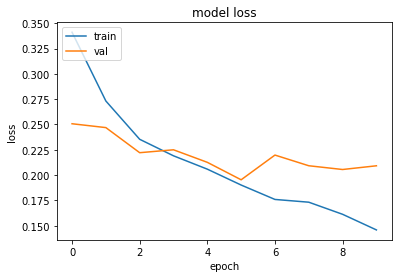

In [30]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
test_tokenized = tokenize(df_test[['TEXT',"CONTEXT"]],tokenizer)
y_test = np.asarray(df_test['LABEL'])

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Evaluation


In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(x=[test_tokenized[0],test_tokenized[1]], batch_size=64, verbose=1)
y_pred_bool = np.asarray([0 if i < 0.5 else 1 for i in y_pred ])

print(classification_report(y_test, y_pred_bool))

#model.save_weights('/content/gdrive/MyDrive/tebano/weights')

17/17 [==============================] - 46s 3s/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       780
           1       0.77      0.92      0.84       266

    accuracy                           0.91      1046
   macro avg       0.87      0.91      0.89      1046
weighted avg       0.92      0.91      0.91      1046



In [ ]:
def clean_text(txt):
    context, text = txt
    text = re.sub("@\S+", " ", text) # Remove Mentions
    text = re.sub("https*\S+", " ", text) # Remove URL
    text = re.sub("#\S+", " ", text) # Remove Hastags
    text = re.sub('&lt;/?[a-z]+&gt;', '', text) # Remove special Charaters
    text = re.sub('#39', ' ', text) # Remove special Charaters
    text = re.sub('<.*?>', '', text) # Remove html
    text = re.sub(' +', ' ', text) # Merge multiple blank spaces
    text = text.replace("<br>", "")
    text = text.replace("</br>", "")
    #text = remove_stop_words(text)
    
    context = re.sub("@\S+", " ", context) # Remove Mentions
    context = re.sub("https*\S+", " ", context) # Remove URL
    context = re.sub("#\S+", " ", context) # Remove Hastags
    context = re.sub('&lt;/?[a-z]+&gt;', '', context) # Remove special Charaters
    context = re.sub('#39', ' ', context) # Remove special Charaters
    context = re.sub('<.*?>', '', context) # Remove html
    context = re.sub(' +', ' ', context) # Merge multiple blank spaces
    context = context.replace("<br>", "")
    context = context.replace("</br>", "")
    #context = remove_stop_words(context)

    return [context, text]

 Use test set as input for the explainer

In [ ]:
n=1046
indices = np.random.choice(len(df_test), size=n, replace=False)

#choose the first n entries in the dataset for explainer
texts = df_train.iloc[indices][["TEXT"]].values.tolist()
contexts = df_train.iloc[indices][["CONTEXT"]].values.tolist()
true_labels = df_train.iloc[indices]["LABEL"].values.tolist()

input_texts = []
for i in range(n):
    text = texts[i][0]
    context = contexts[i][0]
    input_texts.append(clean_text([context,text]))

In [ ]:
#optional, so we don't have to train the model each time we make changes
#model.load_weights("/content/gdrive/MyDrive/tebano")

ValueError: ignored

# Local Explanation Stage

In [ ]:
#drive.mount('/content/gdrive/', force_remount=True)
#from model_wrappers import bert_huggingface_model_wrapper
model_name = "nlpaueb/bert-base-uncased-echr"

%env TOKENIZERS_PARALLELISM=false


#Use this when making changes to wrapper or explainer during current runtime
import importlib
importlib.reload(bert_huggingface_model_wrapper)
importlib.reload(explainer)

bert_model_wrapper = bert_huggingface_model_wrapper.BertModelWrapper(model, tokenizer, clean_function=None, max_seq_length = 500 ,batch_size=16)

coi = -1

# Instantiate the LocalExplainer class for the current mdoel
exp = explainer.LocalExplainer(bert_model_wrapper, model_name=model_name)
local_explanations = exp.fit_transform(input_texts=input_texts,
                                          classes_of_interest=[coi] * len(input_texts),
                                          expected_labels=true_labels,
                                          flag_pos=False,
                                          flag_sen=False,
                                          flag_mlwe=True,
                                          flag_combinations=True,
                                          flag_rnd=False,
                                          flag_offline_mode=True)

local_explanation_path = exp.local_explanations_folder


env: TOKENIZERS_PARALLELISM=false
INFO: Output base experiment created: /content/gdrive/MyDrive/tebano/outputs/nlpaueb/bert-base-uncased-echr/local_explanations_experiments/20230309_131452 .
INFO: Output local explanations folder created inside the base experiment folder: /content/gdrive/MyDrive/tebano/outputs/nlpaueb/bert-base-uncased-echr/local_explanations_experiments/20230309_131452/local_explanations .
INFO: Extracting embedding of all input texts.
33/33 [==============================] - 41s 1s/step
INFO: Embedding extracted successfully.
INFO: Explaining text 1/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 2/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 3/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 4/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 5/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 6/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 7/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 8/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 9/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 10/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 11/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 12/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 13/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 14/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 15/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 16/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 17/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 18/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 19/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 20/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 21/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 22/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 23/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 24/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 25/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 26/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 27/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 28/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 29/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 30/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 31/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 32/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 33/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 34/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 35/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 36/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 37/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 38/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 39/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 40/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 41/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 42/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 43/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 44/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 45/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 46/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 47/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 48/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 49/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 50/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 51/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 52/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 53/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 54/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 55/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 56/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 57/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 58/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 59/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 60/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 61/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 62/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 63/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 64/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 65/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 66/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 67/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 68/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 69/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 70/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 71/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 72/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 73/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 74/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 75/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 76/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 77/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 78/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 79/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 80/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 81/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 82/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 83/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 84/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 85/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 86/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 87/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 88/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 89/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 90/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 91/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 92/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 93/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 94/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 95/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 96/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 97/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 98/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 99/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 100/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 101/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 102/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 103/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 104/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 105/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 106/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 107/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 108/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 109/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 110/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 111/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 112/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 113/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 114/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 115/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 116/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 117/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 118/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 119/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 120/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 121/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 122/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 123/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 124/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 125/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 126/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 127/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 128/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 129/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 130/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 131/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 132/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 133/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 134/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 135/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 136/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 137/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 138/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 139/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 140/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 141/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 142/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 143/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 144/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 145/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 146/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 147/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 148/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 149/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 150/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 151/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 152/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 153/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 154/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 155/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 156/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 157/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 158/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 159/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 160/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 161/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 162/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 163/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 164/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 165/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 166/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 167/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 168/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 169/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 170/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 171/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 172/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 173/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 174/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 175/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 176/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 177/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 178/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 179/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 180/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 181/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 182/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 183/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 184/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 185/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 186/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 187/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 188/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 189/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 190/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 191/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 192/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 193/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 194/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 195/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 196/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 197/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 198/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 199/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 200/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 201/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 202/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 203/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 204/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 205/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 206/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 207/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 208/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 209/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 210/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 211/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 212/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 213/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 214/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 215/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 216/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 217/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 218/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 219/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 220/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 221/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 222/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 223/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 224/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 225/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 226/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 227/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 228/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 229/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 230/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 231/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 232/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 233/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 234/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 235/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 236/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 237/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 238/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 239/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 240/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 241/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 242/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 243/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 244/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 245/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 246/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 247/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 248/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 249/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 250/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 251/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 252/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 253/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 254/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 255/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 256/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 257/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 258/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 259/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 260/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 261/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 262/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 263/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 264/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 265/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 266/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 267/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 268/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 269/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 270/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 271/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 272/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 273/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 274/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 275/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 276/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 277/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 278/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 279/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 280/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 281/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 282/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 283/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 284/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 285/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 286/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 287/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 288/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 289/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 290/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 291/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 292/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 293/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 294/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 295/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 296/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 297/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 298/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 299/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 300/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 301/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 302/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 303/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 304/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 305/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 306/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 307/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 308/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 309/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 310/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 311/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 312/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 313/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 314/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 315/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 316/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 317/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 318/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 319/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 320/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 321/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 322/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 323/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 324/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 325/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 326/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 327/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 328/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 329/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 330/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 331/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 332/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 333/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 334/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 335/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 336/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 337/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 338/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 339/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 340/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 341/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 342/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 343/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 344/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 345/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 346/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 347/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 348/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 349/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 350/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 351/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 352/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 353/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 354/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 355/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 356/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 357/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 358/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 359/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 360/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 361/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 362/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 363/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 364/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 365/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 366/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 367/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 368/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 369/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 370/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 371/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 372/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 373/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 374/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 375/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 376/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 377/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 378/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 379/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 380/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 381/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 382/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 383/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 384/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 385/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 386/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 387/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 388/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 389/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 390/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 391/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 392/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 393/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 394/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 395/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 396/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 397/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 398/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 399/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 400/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 401/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 402/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 403/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 404/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 405/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 406/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 407/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 408/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 409/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 410/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 411/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 412/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 413/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 414/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 415/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 416/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 417/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 418/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 419/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 420/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 421/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 422/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 423/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 424/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 425/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 426/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 427/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 428/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 429/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 430/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 431/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 432/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 433/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 434/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 435/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 436/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 437/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 438/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 439/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 440/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 441/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 442/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 443/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 444/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 445/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 446/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 447/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 448/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 449/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 450/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 451/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 452/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 453/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 454/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 455/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 456/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 457/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 458/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 459/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 460/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 461/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 462/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 463/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 464/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 465/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 466/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 467/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 468/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 469/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 470/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 471/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 472/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 473/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 474/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 475/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 476/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 477/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 478/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 479/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 480/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 481/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 482/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 483/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 484/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 485/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 486/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 487/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 488/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 489/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 490/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 491/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 492/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 493/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 494/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 495/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 496/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 497/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 498/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 499/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 500/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 501/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 502/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 503/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 504/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 505/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 506/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 507/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 508/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 509/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 510/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 511/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 512/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 513/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 514/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 515/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 516/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 517/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 518/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 519/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 520/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 521/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 522/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 523/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 524/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 525/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 526/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 527/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 528/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 529/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 530/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 531/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 532/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 533/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 534/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 535/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 536/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 537/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 538/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 539/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 540/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 541/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 542/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 543/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 544/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 545/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 546/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 547/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 548/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 549/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 550/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 551/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 552/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 553/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 554/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 555/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 556/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 557/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 558/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 559/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 560/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 561/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 562/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 563/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 564/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 565/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 566/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 567/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 568/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 569/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 570/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 571/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 572/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 573/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 574/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 575/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 576/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 577/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 578/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 579/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 580/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 581/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 582/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 583/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 584/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 585/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 586/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 587/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 588/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 589/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 590/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 591/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 592/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 593/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 594/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 595/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 596/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 597/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 598/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 599/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 600/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 601/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 602/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 603/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 604/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 605/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 606/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 607/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 608/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 609/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 610/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 611/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 612/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 613/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 614/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 615/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 616/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 617/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 618/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 619/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 620/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 621/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 622/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 623/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 624/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 625/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 626/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 627/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 628/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 629/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 630/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 631/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 632/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 633/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 634/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 635/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 636/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 637/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 638/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 639/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 640/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 641/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 642/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 643/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 644/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 645/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 646/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 647/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 648/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 649/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 650/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 651/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 652/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 653/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 654/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 655/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 656/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 657/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 658/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 659/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 660/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 661/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 662/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 663/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 664/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 665/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 666/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 667/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 668/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 669/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 670/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 671/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 672/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 673/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 674/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 675/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 676/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 677/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 678/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 679/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 680/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 681/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 682/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 683/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 684/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 685/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 686/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 687/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 688/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 689/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 690/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 691/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 692/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 693/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 694/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 695/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 696/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 697/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 698/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 699/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 700/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 701/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 702/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 703/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 704/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 705/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 706/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 707/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 708/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 709/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 710/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 711/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 712/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 713/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 714/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 715/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 716/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 717/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 718/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 719/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 720/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 721/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 722/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 723/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 724/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 725/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 726/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 727/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 728/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 729/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 730/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 731/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 732/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 733/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 734/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 735/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 736/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 737/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 738/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 739/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 740/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 741/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 742/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 743/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 744/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 745/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 746/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 747/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 748/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 749/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 750/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 751/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 752/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 753/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 754/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 755/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 756/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 757/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 758/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 759/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 760/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 761/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 762/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 763/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 764/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 765/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 766/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 767/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 768/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 769/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 770/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 771/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 772/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 773/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 774/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 775/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 776/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 777/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 778/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 779/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 780/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 781/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 782/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 783/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 784/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 785/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 786/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 787/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 788/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 789/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 790/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 791/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 792/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 793/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 794/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 795/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 796/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 797/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 798/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 799/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 800/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 801/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 802/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 803/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 804/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 805/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 806/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 807/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 808/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 809/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 810/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 811/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 812/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 813/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 814/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 815/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 816/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 817/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 818/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 819/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 820/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 821/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 822/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 823/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 824/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 825/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 826/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 827/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 828/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 829/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 830/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 831/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 832/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 833/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 834/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 835/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 836/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 837/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 838/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 839/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 840/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 841/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 842/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 843/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 844/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 845/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 846/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 847/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 848/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 849/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 850/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 851/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 852/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 853/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 854/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 855/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 856/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 857/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 858/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 859/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 860/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 861/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 862/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 863/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 864/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 865/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 866/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 867/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 868/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 869/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 870/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 871/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 872/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 873/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 874/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 875/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 876/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 877/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 878/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 879/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 880/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 881/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 882/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 883/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 884/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 885/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 886/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 887/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 888/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 889/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 890/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 891/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 892/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 893/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 894/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 895/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 896/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 897/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 898/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 899/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 900/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 901/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 902/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 903/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 904/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 905/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 906/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 907/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 908/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 909/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 910/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 911/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 912/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 913/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 914/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 915/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 916/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 917/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 918/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 919/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 920/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 921/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 922/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 923/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 924/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 925/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 926/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 927/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


INFO: Explaining text 928/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 929/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 930/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 931/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 932/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 933/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 934/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 935/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 936/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 937/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 938/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 939/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 940/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 941/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 942/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 943/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 944/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 945/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 946/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 947/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 948/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 949/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 950/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 951/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 952/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 953/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 954/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 955/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 956/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 957/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 958/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 959/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 960/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 961/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 962/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 963/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 964/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 965/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 966/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 967/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 968/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 969/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 970/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 971/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 972/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 973/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 974/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 975/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 976/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 977/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 978/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 979/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 980/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 981/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 982/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 983/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 984/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 985/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 986/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 987/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 988/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 989/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 990/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 991/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 992/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 993/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 994/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 995/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 996/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 997/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 998/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 999/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1000/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1001/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1002/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1003/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1004/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1005/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1006/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1007/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1008/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1009/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1010/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1011/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1012/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1013/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1014/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1015/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1016/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1017/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1018/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1019/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1020/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1021/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1022/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1023/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1024/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1025/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1026/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1027/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1028/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1029/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1030/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1031/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1032/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1033/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1034/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1035/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1036/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1037/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1038/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1039/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1040/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1041/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1042/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1043/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1044/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1045/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase
INFO: Explaining text 1046/1046 
	INFO: Feature Extraction Phase


/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1 - p_t / p_o)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:60: RuntimeWarning: invalid value encountered in double_scalars
  a = (1 - p_o / p_t)
/content/gdrive/MyDrive/tebano/perturbation_scores.py:67: RuntimeWarning: invalid value encountered in double_scalars
  b = (1 - p_t / p_o)


	INFO: Perturbation Phase
	INFO: Local Explanation Phase


In [ ]:
def get_sorted_importance(matrix, label):
    importance = []
    for lemma, values in matrix.items():
        importance.append((lemma,values[label]))

    importance.sort(key=lambda x: x[1], reverse=True)
    return importance

# Global Explanation Stage

In [ ]:
import nltk
nltk.download('omw-1.4')
#local_explanation_path = "/content/gdrive/MyDrive/tebano/outputs/nlpaueb/bert-base-uncased-echr/local_explanations_experiments/20230206_123409/local_explanations"
nltk.download("wordnet")
#importlib.reload(explainer)
label_names = ["negative","positive"]
global_explainer = explainer.GlobalExplainer(label_list=[0, 1], label_names=label_names)
global_explainer.fit_from_folder(local_explanation_path)
global_explanation_report = global_explainer.transform()
global_path = "/content/gdrive/MyDrive/tebano/outputs/nlpaueb/bert-base-uncased-echr/global_explanations_experiments"
global_explanation_report.save_global_explanation_report(global_path)

GAI_lemma_matrix = global_explanation_report.GAI_lemma_matrix
GRI_lemma_matrix = global_explanation_report.GRI_lemma_matrix

#get relative importance of lemmas for positive labels

In [ ]:
get_sorted_importance(GRI_lemma_matrix,0)

[('.', 33.15346085424122),
 (':', 22.548615524859077),
 ('mr', 21.748606656758206),
 ('he', 18.424407743993214),
 (';', 14.859602123760864),
 ('his', 12.668574975667042),
 ('violation', 11.725531427519307),
 ('administrative', 10.00153771002157),
 ('breach', 9.551372844753194),
 ('claim', 8.55142103685683),
 ('1990', 8.477385937065984),
 ('federal', 8.193694417078643),
 ('5', 8.030488912470464),
 ('10', 7.587030730503393),
 ('account', 7.30419353677817),
 ('following', 7.221646809169673),
 ('1991', 7.20952418630882),
 ('witness', 7.173920991022892),
 (']', 7.075167791579991),
 ('him', 6.961630592817788),
 ('’', 6.847066896926897),
 ('person', 6.767027745918096),
 ('security', 6.745269341260127),
 ('000', 6.7451204992352025),
 ('january', 6.729440368164291),
 ('justice', 6.628426403957828),
 ('[', 6.609819342047254),
 ('june', 6.58310486420709),
 ('damage', 6.5328426279881935),
 ('home', 6.457682347136805),
 ('death', 6.400705790096826),
 ('house', 6.318989612763357),
 ('who', 6.2963530

In [ ]:
get_sorted_importance(GRI_lemma_matrix,1)

[('that', 114.20888229239324),
 ('it', 83.59795833365541),
 ('a', 73.55850071206947),
 ('not', 70.61307148774083),
 ('art', 65.3446824945117),
 ('(', 63.00572256972521),
 ('see', 61.80228105483148),
 ('court', 60.446095558120504),
 ('in', 59.98681060880142),
 (')', 55.483036623904624),
 ('is', 51.15328257443719),
 ('above', 48.415671457857584),
 ('para', 47.50066312341935),
 ('of', 43.33878116556696),
 ('-', 42.63538931574809),
 ('to', 42.60936412022926),
 ('no', 39.71534283465355),
 ('paragraph', 39.692922106451405),
 ('be', 38.14995629337601),
 ('the', 36.83254930531544),
 ('article', 36.24166858374633),
 ('case', 35.2058787423402),
 (',', 34.745292843769136),
 ('convention', 33.81813002537044),
 ('commission', 33.57748186217325),
 ('this', 32.36195819434397),
 ('judgment', 30.039264586223542),
 ('for', 27.079174357170537),
 ('and', 26.958822211516647),
 ('p', 24.793519678412814),
 ('have', 24.291347787130473),
 ('series', 23.539419226559808),
 ('find', 22.89152049603746),
 ('"', 22.

In [ ]:
get_sorted_importance(GAI_lemma_matrix,0)

[('a', 51.26456233206431),
 ('.', 49.89828601070957),
 ('of', 49.255547416651154),
 ('the', 46.92854833969578),
 (',', 46.40746325793163),
 ('and', 40.14354556971767),
 ('to', 39.3843706223624),
 ('in', 38.969305375492574),
 ('on', 27.241768498184676),
 ('(', 22.561888534374447),
 (')', 21.91482900955081),
 ('that', 21.57036747983786),
 ('by', 21.389416201863813),
 ('for', 20.830080774146015),
 ('court', 20.23288749293653),
 ('s', 20.054117646509624),
 ('wa', 18.238017940139578),
 ('it', 17.516035448316696),
 ('applicant', 17.27390009329607),
 ('with', 17.064058728331624),
 ('case', 16.519026603780958),
 ('-', 16.49695980715821),
 ('this', 15.369351055419997),
 ('"', 14.357854665677714),
 ('which', 13.771832107957993),
 ('’', 13.747777348140659),
 ('convention', 13.014654968099547),
 ('article', 12.307402753223078),
 ('under', 12.234181891682308),
 (';', 11.474779399331895),
 ('mr', 11.414312591786),
 ('be', 11.325542988434627),
 ('he', 11.319469643010912),
 ('decision', 11.26020562065

In [ ]:
get_sorted_importance(GAI_lemma_matrix,1)

[('a', 112.96495423748102),
 ('the', 98.15343689555458),
 ('.', 97.34330349421666),
 (',', 90.48679639701614),
 ('of', 88.98076470414334),
 ('that', 86.98874417849531),
 ('in', 86.43432293706046),
 ('(', 83.53277515140074),
 ('to', 82.09624310087176),
 (')', 81.4787354289218),
 ('and', 79.35476486394077),
 ('court', 67.47083236163786),
 ('it', 65.04538750335597),
 ('art', 61.712365930511986),
 ('not', 55.53832515940791),
 ('-', 55.4733297034001),
 ('applicant', 53.80059161168483),
 ('article', 50.75392211555142),
 ('para', 50.720118822720906),
 ('for', 50.71923694855533),
 ('is', 50.5660196257292),
 ('be', 49.50214985514098),
 ('with', 46.982105564077244),
 ('case', 46.37015149895205),
 ('see', 45.830149123041856),
 ('by', 43.59338638536839),
 ('convention', 42.77494736045139),
 ('wa', 42.35686664454037),
 ('paragraph', 40.76816280463383),
 ('this', 40.71510893858414),
 ('"', 39.63602785907834),
 ('on', 39.4966849412921),
 ('s', 38.78822957044111),
 ('an', 37.93312768632406),
 ('under'